In [1]:
# import necessary modules
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime, timedelta
import pandas as pd
from scipy.spatial import distance_matrix
from matplotlib import cm as cm

In [3]:
#get the file path for loading, data file is under the same dir with the notebook
filename="20121015_00_ecmwf_ensemble_forecast.PRESSURE_LEVELS.EUR_LL10.120.pl.nc"
foldername="ECWMF Datasets"
filepath=os.path.join(os.path.dirname(os.getcwd()),foldername,filename)

# read the raw data and extract the needed data
# exrtact the value of Geopotential under the pressure of 500 hPA in the certain
Pressure_Levels_data = nc.Dataset(filepath,"r")
g = 9.80655
# get all the dimension value
nd_1,nd_2,nd_3,nd_4,nd_5 = Pressure_Levels_data.variables['Geopotential_isobaric'][:].shape
# get the necessary raw data
Geopotential_Isobaric_500 = Pressure_Levels_data.variables['Geopotential_isobaric'][0,:,7,:,:]/g
# reshape the dataset into form of (51,41*101)
Geopotential_Isobaric_500_reshaped = np.reshape(Geopotential_Isobaric_500,(nd_2, nd_4 * nd_5))
# prepare the longitude and latitude value for contour
longitude = Pressure_Levels_data['lon'][:]
latitude = Pressure_Levels_data['lat'][:]
(lon, lat) = np.meshgrid(longitude, latitude)

# use PCA to reduce dimensions under the condition of reaching 80% of all the member infomation
exp_var = 0
n_pc = 0
while exp_var < 0.8:
    n_pc = n_pc + 1
    pca = PCA(n_components = n_pc)
    pca.fit(Geopotential_Isobaric_500_reshaped)
    exp_var = sum(pca.explained_variance_ratio_)

# get the transformed raw data in the dimension-reduced space    
pca_transformed_data = pca.transform(Geopotential_Isobaric_500_reshaped)

# recreate the raw data using the eigenvector and transformed data
recreated_raw_data = np.reshape((np.dot(pca_transformed_data, pca.components_) + pca.mean_), (51, 41, 101))
recreated_raw_data_hist = np.reshape(recreated_raw_data,(nd_2, nd_4 * nd_5))

#get the time variable
times=Pressure_Levels_data.variables["time"]
#get the time number
arrDateEnd=nc.num2date(times[:],units=times.units)
#get the time in date format
dateEndDate = datetime.date(arrDateEnd[0]).strftime("%d %b %Y")
dateEndMin = datetime.date(arrDateEnd[0]).strftime("%H:%M")
dateStart=datetime.date(arrDateEnd[0])-timedelta(hours=120)
dateStartDate=dateStart.strftime("%d %b %Y")
dateStartMin=dateStart.strftime("%H:%M")

df = pd.DataFrame({'PC1':pca_transformed_data[:, 0],
                   'PC2':pca_transformed_data[:, 1]})

In [6]:
dist=distance_matrix(Geopotential_Isobaric_500_reshaped,Geopotential_Isobaric_500_reshaped)
colors = ("#E8FF5E","#F9E52D","#FBBD3A","#F2955A","#E07072","#C64D81","#A62C87","#800B86","#530084","#0000D1")
CustomCmap = matplotlib.colors.ListedColormap(colors)

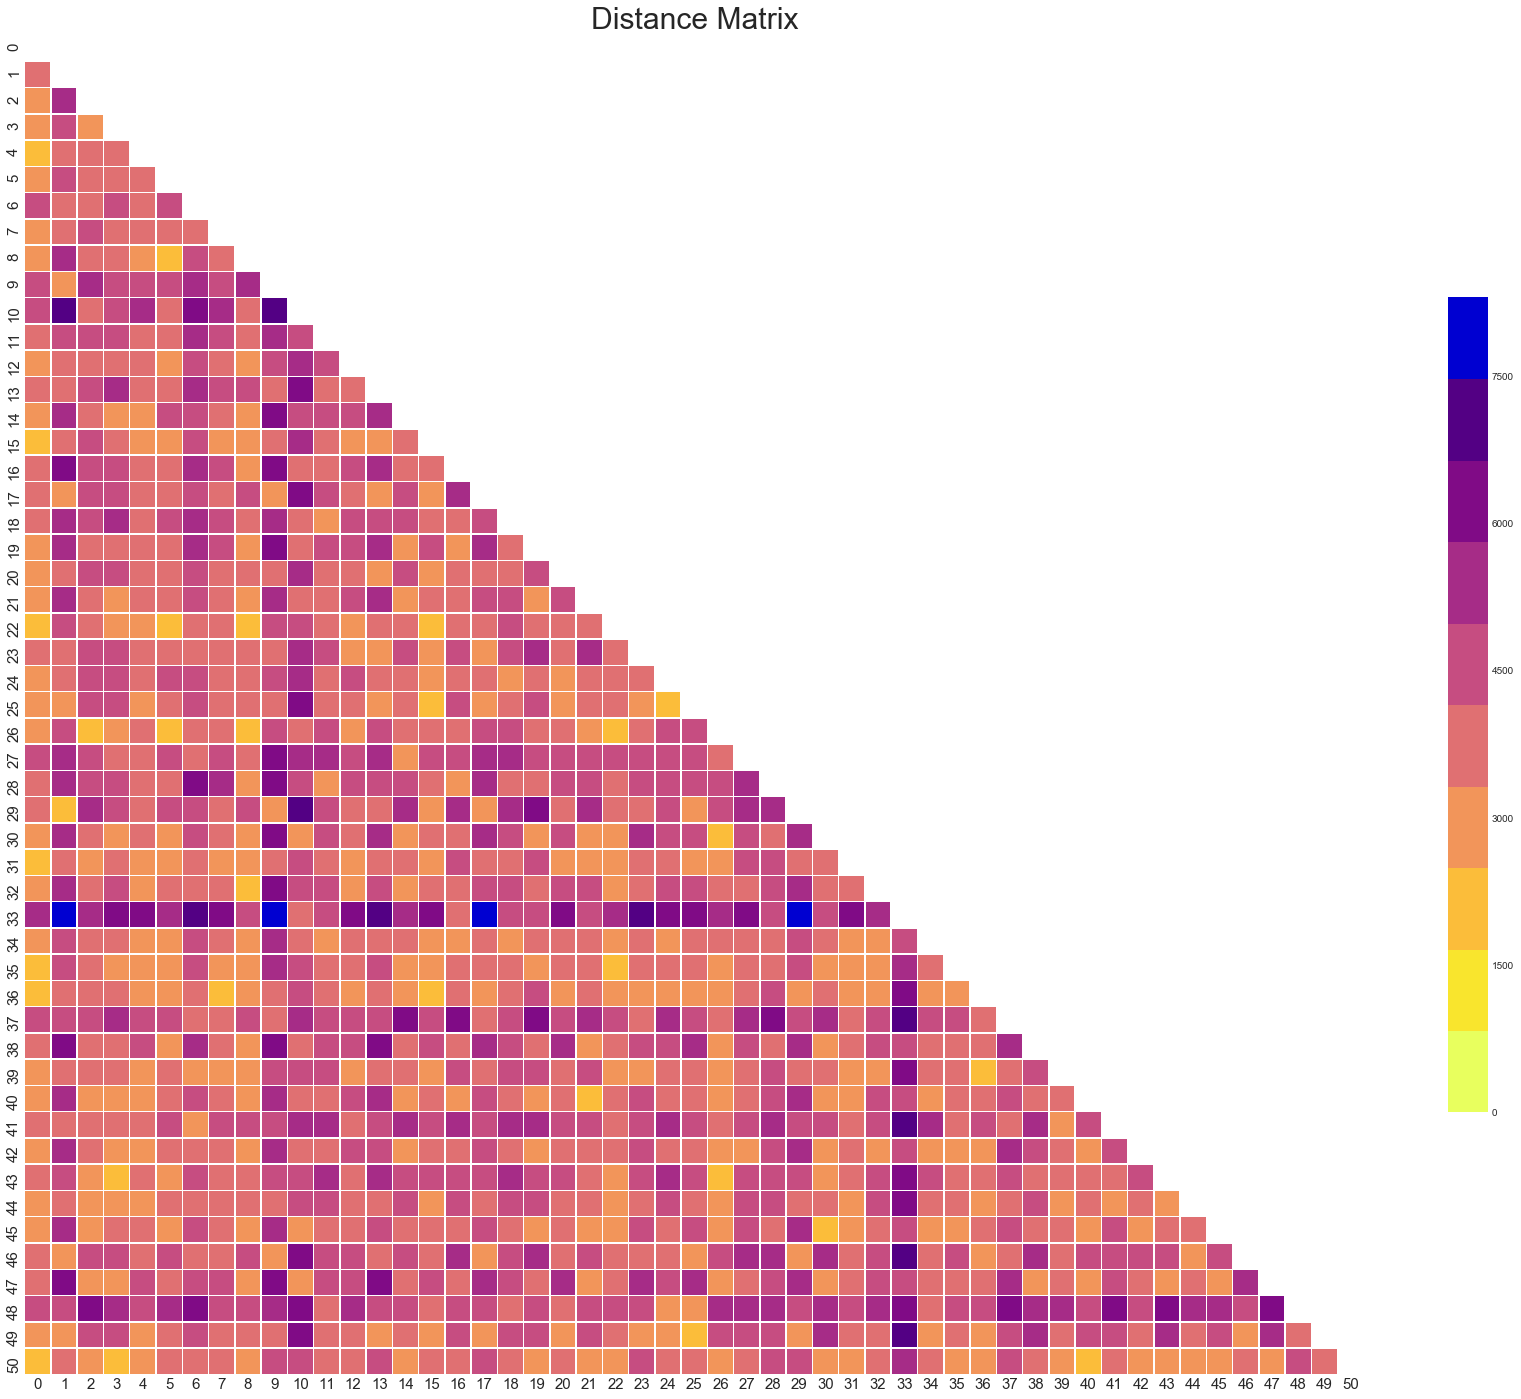

In [17]:
#pp = PdfPages('Distance Matrix.pdf')

mask = np.zeros_like(dist, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.style.use('seaborn-dark')
fig,ax=plt.subplots(figsize=(30,30))
g=sns.heatmap(dist, mask=mask, cmap=CustomCmap, vmin=dist.min(), vmax=dist.max(),square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.set_title("Distance Matrix",loc="center",fontsize=30)
g.set_facecolor('xkcd:white')

#plt.savefig(pp, format='pdf', bbox_inches="tight")
#pp.close()

In [14]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True]])